## This notebook uses regression.ipynb as a base and predicts with XGBoost algorithm only the IA supernovae cases and filter the objects with few interpolation points (on GP preprocess step) in order to obtain a better RMSE score.
The objective of this notebook was to understand the possible errors on regression methods and improve them.

In [1]:
%load_ext autoreload
%autoreload 2
import os 
import sys
import time
import h2o

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from h2o.automl import H2OAutoML

In [2]:
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.modeling.functions_autoML import gen_predictions
from src.modeling.evaluation import get_metrics_from_batchs

In [3]:
df = pd.read_pickle("../../data/structured/df.pkl")
#IA Filter
df = df.loc[df.type_bool == True]

In [4]:
h2o.init(ip="localhost", port=54323)


Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /home/fm/Projects/photometric-redshift-prediction/.photometric_redshift_prediction/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpis03vmnz
  JVM stdout: /tmp/tmpis03vmnz/h2o_fm_started_from_python.out
  JVM stderr: /tmp/tmpis03vmnz/h2o_fm_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,11 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_fm_01asft
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.922 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
best_model = h2o.import_mojo('../../models/models/mojo_50_ensemble/StackedEnsemble_AllModels_AutoML_20201223_115349.zip')

generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1660663670919_1

No model summary for this model

ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 0.0029843621318644473
RMSE: 0.0546293156818246
MAE: 0.04095889497837518
RMSLE: 0.030993632001274172
Mean Residual Deviance: 0.0029843621318644473

ModelMetricsRegressionGeneric: generic
** Reported on cross-validation data. **

MSE: 0.007612769296751577
RMSE: 0.0872511850736228
MAE: 0.06616340247814928
RMSLE: 0.05020608420962501
Mean Residual Deviance: 0.007612769296751577



In [6]:
preds, len_train, len_validation = gen_predictions(df, best_model)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
generic prediction progress: |████████████████████████████████████████████| 100%

 2550 train/test objects  
 and 2528 validation objects


In [7]:
df_eval = df.iloc[-len_validation:]
df_eval['zphot'] = preds.as_data_frame()['predict'].tolist()

/tmp/ipykernel_9559/2585035344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval['zphot'] = preds.as_data_frame()['predict'].tolist()


In [8]:
df_eval["Available Points"] = df_eval.desg.apply(np.count_nonzero, axis=0).apply(sum) + \
df_eval.desi.apply(np.count_nonzero, axis=0).apply(sum) + \
df_eval.desr.apply(np.count_nonzero, axis=0).apply(sum) + \
df_eval.desz.apply(np.count_nonzero, axis=0).apply(sum)

/tmp/ipykernel_9559/3071264684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["Available Points"] = df_eval.desg.apply(np.count_nonzero, axis=0).apply(sum) + \


In [9]:
type(df_eval.desg.SN510924)

numpy.ndarray

In [10]:
df_eval.desg.SN511804

array([[2.98900e+00, 3.11800e+00, 2.58500e+00],
       [1.30550e+01, 9.93400e-02, 2.28400e+00],
       [2.59610e+01, 7.16000e+00, 4.79200e+00],
       [3.39730e+01, 6.43500e+00, 3.69200e+00],
       [4.19730e+01, 5.29000e-01, 1.24900e+00],
       [4.50740e+01, 4.95600e+00, 3.91100e+00],
       [5.18600e+01, 2.22400e+00, 7.69300e+00],
       [5.28480e+01, 4.24300e+01, 2.39300e+01],
       [5.38600e+01, 2.01400e-02, 6.57000e+00],
       [5.48440e+01, 1.14000e-01, 6.04400e+00],
       [5.98480e+01, 4.75400e+00, 4.87300e+00],
       [6.18750e+01, 6.78200e+00, 2.52500e+00],
       [6.99180e+01, 8.19500e+00, 6.56300e+00],
       [7.10820e+01, 1.91400e+00, 1.48900e+00],
       [8.20160e+01, 5.34500e+00, 4.94800e+00],
       [8.48990e+01, 4.25600e+00, 8.82800e+00],
       [1.04961e+02, 1.42700e-01, 2.07400e+00],
       [1.11887e+02, 1.84700e+00, 4.84900e+00],
       [1.15942e+02, 1.07700e+00, 3.05300e+00]])

In [11]:
df_eval

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC,zphot,Available Points
ID,,,,,,,,,,,,,,,,,,,,,
SN510924,"[[8.031000000002678, 5.216, 6.285], [28.879000...","[[13.93699999999808, 2.199, 7.08], [44.8870000...","[[0.0, 2.088, 2.24], [13.042999999997846, 1.82...","[[13.953000000001339, 1.99, 5.422], [36.940999...","[0.0, 0.7661717171717413, 1.5323434343434825, ...","([8.031000000002678, 8.70594949495217, 9.38089...","([13.93699999999808, 14.552414141412289, 15.16...","([0.0, 0.7561111111111435, 1.512222222222287, ...","([13.953000000001339, 14.578232323233673, 15.2...","[10.589545779483814, 8.708973184516886, 7.2444...",...,-16.293731,47.963569,-45.448702,-27.989244,-6.281132,Ia,True,0.85640,0.836854,80
SN511436,"[[1.9689999999973224, 1.07, 3.215], [10.089999...","[[0.01600000000325963, 51.65, 9.372], [2.0, 49...","[[0.0, 35.65, 7.882], [1.9839999999967404, 32....","[[0.9610000000029686, 54.02, 5.43], [9.9409999...","[0.0, 0.8387777777777478, 1.6775555555554955, ...","([1.9689999999973224, 2.6458080808054114, 3.32...","([0.01600000000325963, 0.8545353535386073, 1.6...","([0.0, 0.7076262626262656, 1.4152525252525312,...","([0.9610000000029686, 1.7900707070736157, 2.61...","[9.27014418909458, 8.255517290037698, 7.745205...",...,128.783691,-8.731676,12.435225,17.675975,31.130664,Ia,True,0.58313,0.534478,182
SN511804,"[[2.989000000001397, 3.118, 2.585], [13.055000...","[[0.01599999999598367, 17.51, 3.166], [3.03499...","[[0.0, 1.033, 2.13], [4.082000000002154, 5.482...","[[0.03899999999703141, 19.44, 2.511], [3.06700...","[0.0, 1.1714444444444256, 2.3428888888888513, ...","([2.989000000001397, 4.129939393940805, 5.2708...","([0.01599999999598367, 1.1872828282788337, 2.3...","([0.0, 1.1302525252524929, 2.2605050505049857,...","([0.03899999999703141, 1.208666666663758, 2.37...","[5.178899315805631, 6.259860318410908, 7.21610...",...,22.237930,22.428448,16.678827,0.003466,13.356164,Ia,True,0.99576,0.971700,254
SN511982,"[[3.0120000000024447, 2.981, 2.834], [11.12900...","[[1.0, 9.314, 4.41], [3.0389999999970314, 1.69...","[[3.0279999999984284, 3.245, 2.464], [11.14100...","[[0.0, 7.625, 5.346], [1.9570000000021537, 2.3...","[0.0, 0.7572222222222604, 1.5144444444445209, ...","([3.0120000000024447, 3.728696969699428, 4.445...","([1.0, 1.7371818181818157, 2.4743636363636314,...","([3.0279999999984284, 3.744616161614587, 4.461...","([0.0, 0.7572222222222604, 1.5144444444445209,...","[23.468446299856616, 21.887968070462893, 20.76...",...,-92.468977,155.964305,-34.025248,-57.116588,-24.470505,Ia,True,0.63949,0.659768,86
SN512006,"[[12.781000000002678, 0.2781, 5.225], [22.7890...","[[8.007000000005064, 4.368, 3.015], [13.812000...","[[0.0, 0.04517, 1.765], [12.793000000005122, 3...","[[9.929000000003725, 0.06501, 2.671], [19.7890...","[0.0, 1.1092121212121753, 2.2184242424243505, ...","([12.781000000002678, 13.458080808083512, 14.1...","([8.007000000005064, 9.025393939398965, 10.043...","([0.0, 1.0991919191919162, 2.1983838383838323,...","([9.929000000003725, 10.937919191922933, 11.94...","[5.550365830643399, 5.413142411544863, 5.31422...",...,7.277302,10.927173,38.105298,-23.865254,9.189501,Ia,True,0.99303,0.926702,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN98918,"[[0.0, 3.693, 2.686], [4.984000000004016, 18.7...","[[5.94100000000617, 6.403, 9.191], [13.1840000...","[[4.996000000006461, 8.241, 6.049], [12.141000...","[[0.027000000001862645, 3.092, 4.045], [5.0120...","[0.0, 1.3522323232323885, 2.704464646464777, 4...","([0.0, 1.3017676767676767, 2.6035353535353534,...","([5.94100000000617, 7.233222222228395, 8.52544...","([4.996000000006461, 6.297686868693313, 7.5993...","([0.027000000001862645, 1.2480808080826955, 2....","[16.23491946702271, 16.82763060047037, 17.3637...",...,11.915896,-56.738013,-27.269292,9.479856,7.803209,Ia,True,0.76083,0.874126,170
SN99404,"[[0.0, 6.586, 10.48], [15.980999999999767, 166...","[[22.0,

In [12]:
df_eval["delta_z"] = (df_eval["REDSHIFT_SPEC"] - df_eval["zphot"])/df_eval["REDSHIFT_SPEC"]

/tmp/ipykernel_9559/272440695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["delta_z"] = (df_eval["REDSHIFT_SPEC"] - df_eval["zphot"])/df_eval["REDSHIFT_SPEC"]


In [13]:
df_eval["delta_z"]

ID
SN510924    0.022823
SN511436    0.083432
SN511804    0.024162
SN511982   -0.031710
SN512006    0.066793
              ...   
SN98918    -0.148911
SN99404     0.036004
SN99438    -0.058526
SN99457    -0.118675
SN99946    -0.077822
Name: delta_z, Length: 2528, dtype: float64

In [14]:
df_eval["delta_z_abs"] = df_eval["delta_z"].abs()

/tmp/ipykernel_9559/1151772463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval["delta_z_abs"] = df_eval["delta_z"].abs()


In [15]:
df_dz = df_eval[["REDSHIFT_SPEC", "zphot", "delta_z", "delta_z_abs", "Available Points"]]

<AxesSubplot:xlabel='REDSHIFT_SPEC'>

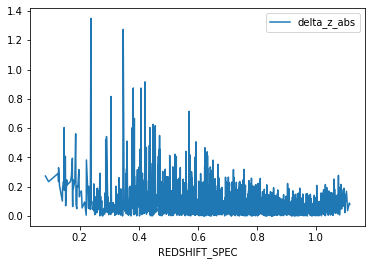

In [16]:
df_dz.sort_values("REDSHIFT_SPEC")[["REDSHIFT_SPEC", "delta_z_abs"]].plot("REDSHIFT_SPEC")

In [17]:
z, dz = df_dz.REDSHIFT_SPEC, df_dz.delta_z_abs

In [18]:
plt.rcParams.keys()

NameError: name 'plt' is not defined

In [18]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc("legend", facecolor="b")
# plt.rc("hatch", color="b")

In [19]:
df_dz

,REDSHIFT_SPEC,zphot,delta_z,delta_z_abs,Available Points
ID,,,,,
SN510924,0.85640,0.836854,0.022823,0.022823,80
SN511436,0.58313,0.534478,0.083432,0.083432,182
SN511804,0.99576,0.971700,0.024162,0.024162,254
SN511982,0.63949,0.659768,-0.031710,0.031710,86
SN512006,0.99303,0.926702,0.066793,0.066793,125
...,...,...,...,...,...
SN98918,0.76083,0.874126,-0.148911,0.148911,170
SN99404,0.89529,0.863056,0.036004,0.036004,275
SN99438,0.75966,0.804120,-0.058526,0.058526,374


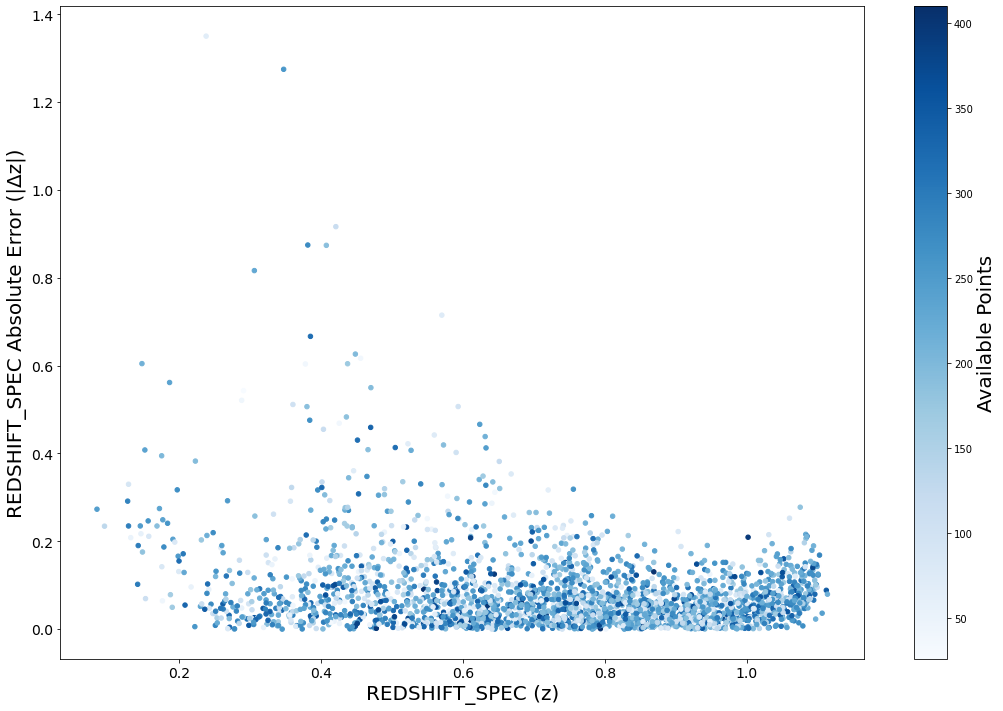

In [27]:
fig = df_dz.plot.scatter(x="REDSHIFT_SPEC", y="delta_z_abs",
                         c="Available Points", colormap='Blues',
                         figsize=(18, 12), sharex=False, fontsize=14).figure
# fig.tick_params(labelsize=6)
plt.xlabel('REDSHIFT_SPEC (z)')
plt.ylabel(u'REDSHIFT_SPEC Absolute Error (|Δz|)')
fig.savefig('t.pdf')


In [21]:
df_dz.sort_values("REDSHIFT_SPEC")[["REDSHIFT_SPEC", "delta_z_abs"]]

,REDSHIFT_SPEC,delta_z_abs
ID,,
SN603327,0.08385,0.273149
SN882878,0.09448,0.234505
SN717371,0.12712,0.291500
SN840198,0.12833,0.234969
SN553425,0.12835,0.329962
...,...,...
SN681213,1.10073,0.123298
SN746675,1.10249,0.168632
SN96615,1.10620,0.036357
